In [1]:
from Dataset.DidiDataset import DidiTrajectoryDataset, collectFunc
from Models.StableDiffusion import *
from Models.VAE import *
from DiffusionManager import DiffusionManager
from Utils import MovingAverage, loadModel, visualizeTraj

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from tqdm import tqdm

c:\Users\lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Configs

In [2]:
chengdu_nov_dataset_args = {
    "dataset_root": "E:/Data/Didi/chengdu/nov",
    "traj_length": 199,
    "feature_mean": [21599.4980, 104.0789535914567, 30.680879399098956],    # time lon lat
    "feature_std": [12470.9102, 0.0032705687484356773, 0.018204423046522103],
}

xian_nov_dataset_args = {
    "dataset_root": "E:/Data/Didi/xian/nov",
    "traj_length": 199,
    "feature_mean": [21599.4980, 108.950773428688, 34.24354179925547],    # time lon lat
    "feature_std": [12470.9102, 0.02129110045580343, 0.019358855648211895],
}

diffusion_args = {
    "min_beta": 0.0001,
    "max_beta": 0.05,
    "max_diffusion_step": 500,
}

model_args = {
    "traj_dim": 4,
    "channel_schedule": [128, 256, 512, 1024],
    "diffusion_steps": diffusion_args["max_diffusion_step"],
    "res_blocks": 4,
}


init_lr = 1e-3
lr_reduce_factor = 0.5
lr_reduce_patience = 2000

# Colab can have 51GB RAM or 12.7GB RAM, GPU is Tesla T4 which has 15GB RAM
files_per_part = 2
batch_size = 32
epochs = 100
log_interval = 100
save_interval = 10000

# Prepare

In [3]:
dataset = DidiTrajectoryDataset(**xian_nov_dataset_args)

In [5]:
model = SDUNet_CAR(**model_args).cuda()
loadModel(model, "Runs\colab\SDUNet\SDUNet_CAR_10000.pth")
model.eval()

vae = VAE_InvTrans().cuda()
loadModel(vae, "Runs/colab/InverseVAE/VAE_InvTrans_last_kld1e6.pth")
vae.eval()

diff_manager = DiffusionManager(**diffusion_args)

In [4]:
dataset.loadNextFiles(1)

Loading E:/Data/Didi/xian/nov\gps_20161101.pt


True

In [6]:
dataloader = dataloader = DataLoader(dataset, batch_size=100, shuffle=False, collate_fn=collectFunc)

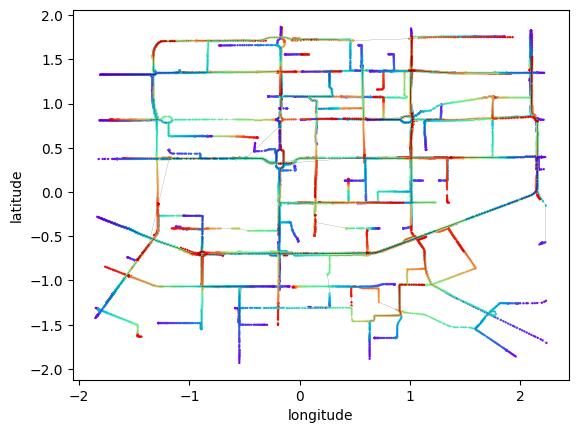

In [7]:
traj_0, cat_attr, num_attr, times = dataloader.__iter__().__next__()
for i in range(100):
    visualizeTraj(traj_0[i], times[i])

In [8]:
t_max = torch.tensor([diffusion_args["max_diffusion_step"] - 1] * 100).to(torch.long).cuda()
enc_0 = vae.encode(traj_0)
epsilon = torch.randn_like(enc_0).cuda()
enc_t = diff_manager.diffusionForward(enc_0, t_max, epsilon)

In [9]:
enc_recover = diff_manager.diffusionBackward(enc_t, cat_attr, num_attr, model)
traj_recover = vae.decode(enc_recover)

In [9]:
# without vae
t_max = torch.tensor([diffusion_args["max_diffusion_step"] - 1] * 100).to(torch.long).cuda()
epsilon = torch.randn_like(traj_0).cuda()
traj_t = diff_manager.diffusionForward(traj_0, t_max, epsilon)
traj_recover = diff_manager.diffusionBackward(traj_t, cat_attr, num_attr, model)

100%|██████████| 100/100 [00:00<00:00, 242.56it/s]


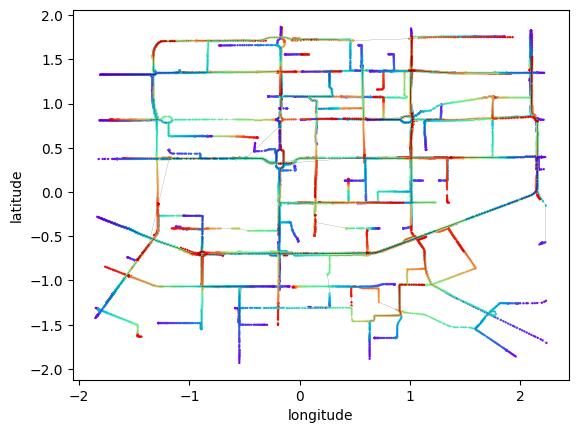

In [10]:
for i in tqdm(range(100)):
    recover_traj_i = traj_0[i].detach()  # (2, N)
    visualizeTraj(recover_traj_i, times[i])
    # smooth_traj_i = F.avg_pool1d(recover_traj_i.unsqueeze(0), kernel_size=3, stride=1, padding=0).squeeze(0)  # (2, N)
    # smooth_traj_i = torch.cat([recover_traj_i[:, 0:1], smooth_traj_i, recover_traj_i[:, -1:]], dim=1)  # (2, N+2)
    # visualizeTraj(smooth_traj_i, times[i])


In [11]:
import matplotlib.pyplot as plt

def getPointDistribution(traj_dataset: torch.Tensor, n_grids: int = 16, normalize: bool = True):
    # traj_dataset: (B, 2, L)
    # Get the distribution of all points in the dataset
    # return: (B, 2, L)

    traj_dataset = traj_dataset.transpose(1, 2).reshape(-1, 2).contiguous()     # (B*L, 2)
    
    # STEP 1. get min and max
    min_lon = traj_dataset[:, 0].min().item()
    max_lon = traj_dataset[:, 0].max().item()
    min_lat = traj_dataset[:, 1].min().item()
    max_lat = traj_dataset[:, 1].max().item()

    # STEP 2. split city into 16x16 grid
    lon_grid = torch.linspace(min_lon, max_lon, n_grids, device=traj_dataset.device)
    lat_grid = torch.linspace(min_lat, max_lat, n_grids, device=traj_dataset.device)

    # STEP 3. count points in each grid
    point_count = torch.zeros((n_grids, n_grids))
    for point in traj_dataset:
        lon_idx = torch.searchsorted(lon_grid, point[0])
        lat_idx = torch.searchsorted(lat_grid, point[1])
        point_count[lon_idx, lat_idx] += 1
    
    # STEP 4. normalize
    if normalize:
        point_count = (point_count + 1) / point_count.sum()
    return point_count


def getStartDistribution(traj_dataset: torch.Tensor):
    # traj_dataset: (B, 2, L)
    # Get the distribution of start points in the dataset
    # return: (B, 2, L)

    return getPointDistribution(traj_dataset[:, :, [0,]])

def getEndDistribution(traj_dataset: torch.Tensor):
    # traj_dataset: (B, 2, L)
    # Get the distribution of end points in the dataset
    # return: (B, 2, L)

    return getPointDistribution(traj_dataset[:, :, [-1,]])


def getLengthDistribution(traj_dataset: torch.Tensor):
    # calculating the Euclidean distance between consecutive points
    # traj_dataset: (B, 2, L)
    # return: (B)
    traj_lengths = torch.zeros(traj_dataset.shape[0], device=traj_dataset.device)   # (B)
    for i, traj in enumerate(traj_dataset):   # (2, L)
        traj_lengths[i] = torch.sqrt(torch.sum((traj[:, 1:] - traj[:, :-1]) ** 2, dim=0)).sum()
    
    # get distribution
    bars = torch.linspace(0.0, 10.0, 64, device=traj_dataset.device)
    length_dist = torch.zeros((64), device=traj_dataset.device)
    for i in range(traj_lengths.shape[0]):
        idx = torch.searchsorted(bars, traj_lengths[i])
        length_dist[idx] += 1
    length_dist = (length_dist + 0.1) / length_dist.sum()
    return length_dist



def showDistribution(point_count: torch.Tensor):
    # point_count: (16, 16)
    plt.imshow(point_count.cpu().numpy(), cmap="gray")
    plt.show()


def JSD(P: torch.Tensor, Q: torch.Tensor) -> float:
    """ Compute the Jensen-Shannon divergence between two distributions.

    :param P: Batch of original distributions. (B, ...)
    :param Q: Batch of generated distributions. (B, ...)
    :return: JSD score
    """
    # Compute KL divergence between P and the average distribution of P and Q
    P_avg = 0.5 * (P + Q)
    kl_divergence_P = torch.nn.functional.kl_div(P.log(), P_avg, reduction='batchmean')
    
    # Compute KL divergence between Q and the average distribution of P and Q
    Q_avg = 0.5 * (P + Q)
    kl_divergence_Q = torch.nn.functional.kl_div(Q.log(), Q_avg, reduction='batchmean')
    
    # Compute Jensen-Shannon Divergence
    jsd_score = 0.5 * (kl_divergence_P + kl_divergence_Q)
    
    return jsd_score.item()

In [12]:
traj_0_point_dist = getPointDistribution(traj_0)
traj_recover_point_dist = getPointDistribution(traj_recover)
JSD(traj_0_point_dist, traj_recover_point_dist)

0.009215841069817543

In [13]:
traj_0_s_dist = getStartDistribution(traj_0)
traj_recover_s_dist = getStartDistribution(traj_recover)
JSD(traj_0_s_dist, traj_recover_s_dist)

0.005782411899417639

In [14]:
traj_0_e_dist = getEndDistribution(traj_0)
traj_recover_e_dist = getEndDistribution(traj_recover)
JSD(traj_0_e_dist, traj_recover_e_dist)

0.004849916789680719

In [15]:
traj_0_length_dist = getLengthDistribution(traj_0)
traj_recover_length_dist = getLengthDistribution(traj_recover)
JSD(traj_0_length_dist, traj_recover_length_dist)

0.0006722303805872798

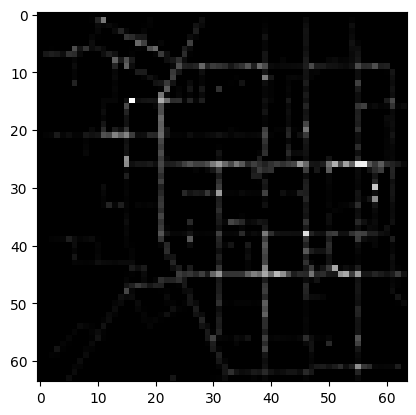

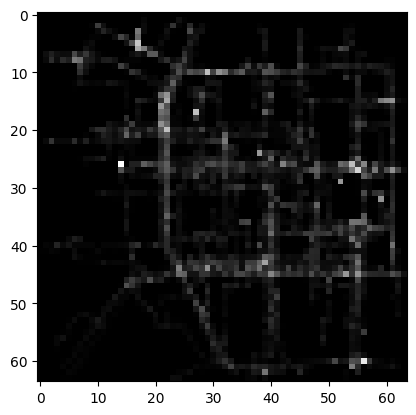

In [ ]:
traj_0_point_dist_64 = getPointDistribution(traj_0, n_grids=64, normalize=False)
traj_recover_point_dist_64 = getPointDistribution(traj_recover, n_grids=64, normalize=False)
showDistribution(traj_0_point_dist_64)
plt.show()
showDistribution(traj_recover_point_dist_64)
plt.show()
